In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install torchinfo
!pip install -U catalyst

     |████████████████████████████████| 512kB 8.3MB/s 
     |████████████████████████████████| 122kB 52.4MB/s 
     |████████████████████████████████| 645kB 47.9MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import torchvision
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchinfo import summary

## week12: Pytorch CNN implementation

Today we're gonna use modern CNN architecture features to create our own models and train them from scratch.

In [4]:
from tqdm.auto import tqdm
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from random import choice
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# 1. Loading CIFAR10 Dataset

Let's use CIFAR10 dataset for our CNN model development as a small and simple toy dataset.
It is easy to download it using torchvision.datasets.

In [5]:
from torchvision import datasets
train_ds = datasets.CIFAR10('./cifar10', train=True, download=True)
val_ds = datasets.CIFAR10('./cifar10', train=False, download=True)
print(f'Train / val size: {len(train_ds)} / {len(val_ds)}')


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
Train / val size: 50000 / 10000


let's see what classes/labels we have and make sure that we have the same classes in train/val parts

In [6]:
num_classes = len(train_ds.classes)
print('Training classes: ', train_ds.classes)
print('Validation classes: ', val_ds.classes)

Training classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Validation classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's plot some images from the dataset too:

In [7]:
def sample_from_dataset(dataset):
    class_names = dataset.classes
    num_classes = len(class_names)
    label_to_idx = defaultdict(list)
    for i, sample in enumerate(dataset):
        data, lbl = sample
        label_to_idx[lbl].append(i)
    
    grid_size = (2, int(num_classes / 2 + 0.5))
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,4)
    for lbl in range(num_classes):
        img, _ = dataset[choice(label_to_idx[lbl])]
        sample_title = '%s (label=%d)' % (class_names[lbl], lbl)
        axarr[lbl % grid_size[0], lbl // grid_size[0]].imshow(img)
        axarr[lbl % grid_size[0], lbl // grid_size[0]].set_title(sample_title)
        axarr[lbl % grid_size[0], lbl // grid_size[0]].axis('off')
    return

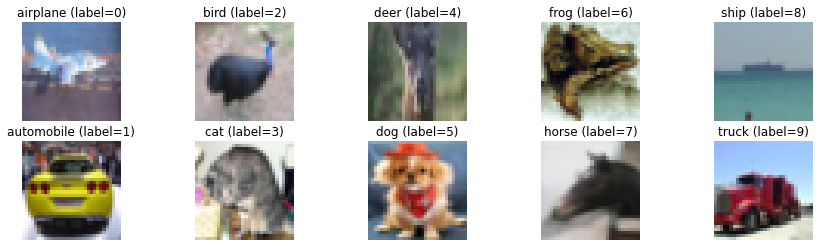

In [8]:
sample_from_dataset(train_ds)

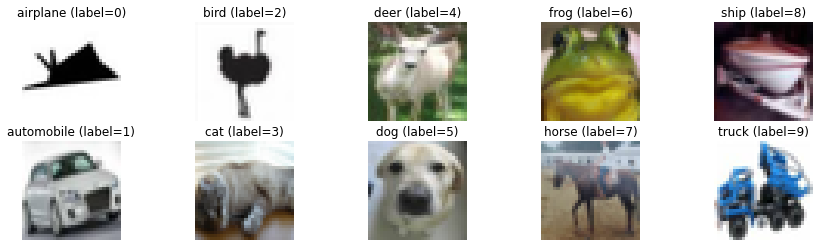

In [9]:
sample_from_dataset(val_ds)

We see that image classes are correct for both training and validation dataset parts, so we can use this dataset in our experiments.


# 2. Data Augmentation and Data Loaders

Image data is needed to be pre-processed before feeding it into any CNN forward pass.

Such pre-processing shall include:
* converting image np.ndarrays / PIL images to torch tensors
* scaling image pixel values from [0;255] to [0;1]
* (optionally) normalizing data by subtracting some mean value and dividing by some std value.

Such pre-processing is done using torchvision.transforms module.
The same module implements different random image perturbations, that can be used for image augmentation during CNN training.

**Question:** name at least 5 image augmentation, that we can apply to image classification task here?

In [10]:
# let's use ImageNet mean and std values for image pixel values
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

In [11]:
from torchvision import datasets, transforms

base_transforms = [transforms.ToTensor(), transforms.Normalize(means, stds)]
augmented_transforms = [
    # add your own augmentations here
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(hue=0.01, brightness=0.3, contrast=0.3, saturation=0.3)
]
augmented_transforms += base_transforms

transform_basic = transforms.Compose(base_transforms)
transform_augment = transforms.Compose(augmented_transforms)

In [12]:
train_ds = datasets.CIFAR10('./cifar10', train=True, download=True, transform=transform_augment)
val_ds = datasets.CIFAR10('./cifar10', train=False, download=True, transform=transform_basic)

Files already downloaded and verified
Files already downloaded and verified


Combining image tensors to image batches may be easily done using torch.utils.data.DataLoader. Don't forget to set up the batch size, depending on your computational capabilities. For Google Colab batch size of 256 is enough.

In [13]:
batch_size = 256
train_batch_gen = torch.utils.data.DataLoader(train_ds, 
                                              batch_size=batch_size,
                                              shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_ds, 
                                              batch_size=batch_size,
                                              shuffle=False)

In [14]:
img_batch, label_batch = next(iter(train_batch_gen))
print(f'Label tensor size: {label_batch.size(0)}')
print(f'Batch tensor size [B, C, H, W] = {img_batch.size()}')
print(f'Batch tensor range: min = {img_batch.min().item():.4f} max = {img_batch.max().item():.4f} ')

Label tensor size: 256
Batch tensor size [B, C, H, W] = torch.Size([256, 3, 32, 32])
Batch tensor range: min = -2.4291 max = 2.7537 


In [15]:
def sample_from_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = batch_gen.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(stds * batch_image_ndarray + means, 0, 1)
        
        # display batch samples with labels
        sample_title = '%s (%d)' % (class_names[label_batch[i]], label_batch[i])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    return

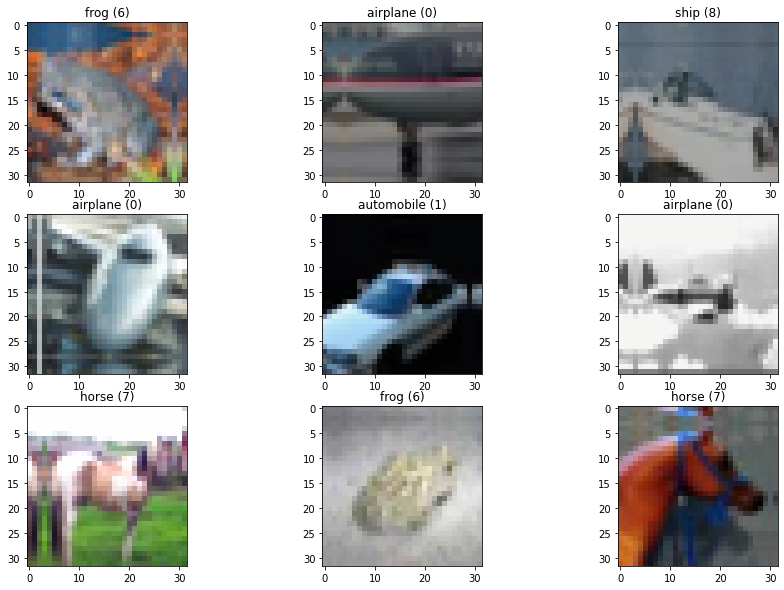

In [16]:
sample_from_generator(train_batch_gen)

In [17]:
num_classes = len(train_ds.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: ', device)

Using device:  cuda


# 3. Baseline Model Implementation

Let's review the implementation of base layers for several models, that were discussed during the lecture: ResNet, DenseNet, SE Blocks etc.

## 3.1 Simple VGG-like Model

For reference let's use VGG-like model performance baseline.

In [18]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.relu = nn.LeakyReLU()
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, in_tensor):
        out = self.conv(in_tensor)
        out = self.relu(self.bn(out))
        return out

class BaseModel(nn.Module):
    def __init__(self, num_classes):
        super(BaseModel, self).__init__()
        self.num_classes = num_classes
        self.in_preproc = nn.Sequential(
            ConvBlock(3, 64),
            nn.MaxPool2d((2, 2)))
        self.features = nn.Sequential(
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            nn.MaxPool2d((2, 2)),
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            nn.MaxPool2d((2, 2)),
            ConvBlock(128, 128),
            nn.AdaptiveAvgPool2d(1))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, self.num_classes))
        
    def forward(self, in_tensor):
        x = self.in_preproc(in_tensor)
        x = self.features(x)
        feat = torch.flatten(x, 1)
        logits = self.classifier(feat)
        return logits

In [19]:
def cifar_model_summary(model, device):
    col_names = ("output_size", "output_size", "num_params", "mult_adds")
    print(summary(model, (1, 3, 32, 32), device=device, col_names=col_names))
    return

In [ ]:
cifar_model_summary(BaseModel(num_classes), device)

Layer (type:depth-idx)                   Output Shape              Output Shape              Param #                   Mult-Adds
BaseModel                                --                        --                        --                        --
├─Sequential: 1-1                        [1, 64, 16, 16]           [1, 64, 16, 16]           --                        --
│    └─ConvBlock: 2-1                    [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           [1, 64, 32, 32]           1,728                     1,769,472
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           [1, 64, 32, 32]           128                       64
│    │    └─LeakyReLU: 3-3               [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    └─MaxPool2d: 2-2                    [1, 64, 16, 16]           [1, 64, 16, 16]           --                        --
├─Sequenti

# 4. CNN Training

Let's use __Catalyst__ library to simplify CNN training, validation and checkpointing.

In [20]:
# it is merely a helper util for cleaner output
from catalyst.loggers.console import ConsoleLogger
from typing import Dict
from catalyst.core.logger import ILogger

def my_format_metrics(dct: Dict):
    return " | ".join([f"{k}: {float(dct[k]):.3f}" for k in sorted(dct.keys())])

class CustomLogger(ConsoleLogger):
      def log_metrics(
        self,
        metrics: Dict[str, float],
        scope: str = None,
        # experiment info
        run_key: str = None,
        global_epoch_step: int = 0,
        global_batch_step: int = 0,
        global_sample_step: int = 0,
        # stage info
        stage_key: str = None,
        stage_epoch_len: int = 0,
        stage_epoch_step: int = 0,
        stage_batch_step: int = 0,
        stage_sample_step: int = 0,
        # loader info
        loader_key: str = None,
        loader_batch_len: int = 0,
        loader_sample_len: int = 0,
        loader_batch_step: int = 0,
        loader_sample_step: int = 0,
        ) -> None:
        """Logs loader and epoch metrics to stdout."""
        if scope == "loader" and self._log_loader_metrics:
            prefix = f"{loader_key} ({stage_epoch_step}/{stage_epoch_len}) "
            msg = prefix + my_format_metrics(metrics)
            print(msg)
        elif scope == "epoch" and self._log_epoch_metrics:
            # @TODO: trick to save pure epoch-based metrics, like lr/momentum
            prefix = f"* Epoch ({stage_epoch_step}/{stage_epoch_len}) "
            msg = prefix + my_format_metrics(metrics["_epoch_"])
            print(msg)

In [21]:
from catalyst import dl, utils
runner = dl.SupervisedRunner(
    input_key="img", output_key="logits", target_key="targets", loss_key="loss")

In [22]:
loaders = {
    "train": train_batch_gen,
    "valid": val_batch_gen}

In [ ]:
model = BaseModel(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    loggers={'console': CustomLogger()},
    num_epochs=6,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk_args=(1, 3, 5)),
    ],
    logdir="./logs",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
    load_best_on_end=True,
)

We also need some validation code to reload the best checkpoint, evaluate it using our validation data and compute metrics.

In [23]:
from sklearn.metrics import accuracy_score

def load_ckpt(path, model, device=torch.device('cpu')):
    """
    Load saved checkpoint weights to model
    :param path: full path to checkpoint
    :param model: initialized model class nested from nn.Module()
    :param device: base torch device for validation
    :return: model with loaded 'state_dict'
    """
    assert os.path.isfile(path), FileNotFoundError(f"no file: {path}")
    
    ckpt = torch.load(path, map_location=device)
    ckpt_dict = ckpt['model_state_dict']
    model_dict = model.state_dict()
    ckpt_dict = {k: v for k, v in ckpt_dict.items() if k in model_dict}
    model_dict.update(ckpt_dict)
    model.load_state_dict(model_dict)
    return model

@torch.no_grad()
def validate_model(model, loader, device):
    """
    Evaluate implemented model
    :param model: initialized model class nested from nn.Module() with loaded state dict
    :param loader batch data loader for evaluation set
    :param device: base torch device for validation
    :return: dict performance metrics
    """
    label_list = []
    pred_list = []
    model = model.to(device)
    for data_tensor, lbl_tensor in loader:
        lbl_values = lbl_tensor.cpu().view(-1).tolist()
        label_list.extend(lbl_values)
        logits = model(data_tensor.to(device))
        scores = F.softmax(logits.detach().cpu(), 1).numpy()
        pred_labels = np.argmax(scores, 1)
        pred_list.extend(pred_labels.ravel().tolist())

    labels = np.array(label_list)
    predicted = np.array(pred_list)
    acc = accuracy_score(labels, predicted)
    print(f"model accuracy: {acc:.4f}")
    metric_dict = {
        'accuracy': acc
    }
    return metric_dict

Let's test it: first we re-initialize the model and load the checkpoint state dict

In [ ]:
ckpt_fp = os.path.join('logs', 'checkpoints', 'best.pth')
mod = BaseModel(num_classes=num_classes)
mod = load_ckpt(ckpt_fp, mod).eval()

Then we can run validation code using the corresponding data loader

In [ ]:
new_runner = validate_model(mod, loaders['valid'], device)

model accuracy: 0.7713


## 5. Implementing More Layers

Let's see how one can implement some state-of-the-art layers, such as residual blocks, densenet dense and transition blocks, etc.
This migh help you when building your CNN model from scratch.

### 5.1 ResNet Implementation

In [24]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(ResidualBlock, self).__init__()
        if norm_layer is None: norm_layer = nn.BatchNorm2d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.dropout1 = nn.Dropout(.1)
        self.bn1 = norm_layer(planes)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = conv3x3(planes, planes)
        self.dropout2 = nn.Dropout(.1)
        self.bn2 = norm_layer(planes)
        self.relu2 = nn.LeakyReLU()
        self.downsample = downsample
        if inplanes != planes:
            self.downsample = nn.Sequential(nn.Conv2d(inplanes, planes, kernel_size = 1, stride = stride, bias = False),
                                            nn.BatchNorm2d(planes))
        else:
            self.downsample = lambda x: x
        self.stride = stride

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.dropout1(out)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.dropout2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu2(out)

        return out

In [25]:
#test ResNet Block
resnet_block = ResidualBlock(32, 64, norm_layer = None)
resnet_block

ResidualBlock(
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (downsample): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [26]:
class BaseResNet(nn.Module):
    def __init__(self, block, layers, num_classes, norm_layer=None):
        super(BaseResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.layer1 = self._make_layer(block, self.inplanes, layers[0])
        self.layer2 = self._make_layer(block, self.inplanes * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, self.inplanes * 4, layers[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(self.inplanes, num_classes)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes, stride),
                norm_layer(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, norm_layer))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)


        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
layers = [8, 16, 24]
resnet_model = BaseResNet(ResidualBlock, layers, num_classes)
cifar_model_summary(resnet_model, device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-3)

Layer (type:depth-idx)                   Output Shape              Output Shape              Param #                   Mult-Adds
BaseResNet                               --                        --                        --                        --
├─Conv2d: 1-1                            [1, 64, 32, 32]           [1, 64, 32, 32]           1,728                     1,769,472
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           [1, 64, 32, 32]           128                       64
├─ReLU: 1-3                              [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           [1, 64, 16, 16]           --                        --
├─Sequential: 1-5                        [1, 64, 16, 16]           [1, 64, 16, 16]           --                        --
│    └─ResidualBlock: 2-1                [1, 64, 16, 16]           [1, 64, 16, 16]           --                        --
│    │    

In [ ]:
runner.train(
    model=resnet_model,
    criterion=criterion,
    optimizer=optimizer,
    # scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 6]),
    loaders=loaders,
    loggers={'console': CustomLogger()},
    num_epochs=12,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk_args=(1, 3, 5)),
    ],
    logdir="./logs/resnet",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
    load_best_on_end=True,
)


train (1/12) accuracy: 0.225 | accuracy/std: 0.073 | accuracy01: 0.225 | accuracy01/std: 0.073 | accuracy03: 0.535 | accuracy03/std: 0.112 | accuracy05: 0.746 | accuracy05/std: 0.110 | loss: 2.494 | loss/mean: 2.494 | loss/std: 1.060 | lr: 0.001 | momentum: 0.900



valid (1/12) accuracy: 0.143 | accuracy/std: 0.021 | accuracy01: 0.143 | accuracy01/std: 0.021 | accuracy03: 0.395 | accuracy03/std: 0.032 | accuracy05: 0.571 | accuracy05/std: 0.030 | loss: 1765.562 | loss/mean: 1765.562 | loss/std: 236.045 | lr: 0.001 | momentum: 0.900
* Epoch (1/12) 



train (2/12) accuracy: 0.221 | accuracy/std: 0.049 | accuracy01: 0.221 | accuracy01/std: 0.049 | accuracy03: 0.536 | accuracy03/std: 0.079 | accuracy05: 0.745 | accuracy05/std: 0.069 | loss: 2.206 | loss/mean: 2.206 | loss/std: 0.216 | lr: 0.001 | momentum: 0.900



valid (2/12) accuracy: 0.305 | accuracy/std: 0.033 | accuracy01: 0.305 | accuracy01/std: 0.033 | accuracy03: 0.665 | accuracy03/std: 0.027 | accuracy05: 0.851 | accuracy05/std: 0.023 | loss: 1.908 | loss/mean: 1.908 | loss/std: 0.195 | lr: 0.001 | momentum: 0.900
* Epoch (2/12) 



train (3/12) accuracy: 0.328 | accuracy/std: 0.036 | accuracy01: 0.328 | accuracy01/std: 0.036 | accuracy03: 0.677 | accuracy03/std: 0.038 | accuracy05: 0.857 | accuracy05/std: 0.027 | loss: 1.853 | loss/mean: 1.853 | loss/std: 0.105 | lr: 0.001 | momentum: 0.900



valid (3/12) accuracy: 0.373 | accuracy/std: 0.029 | accuracy01: 0.373 | accuracy01/std: 0.029 | accuracy03: 0.715 | accuracy03/std: 0.027 | accuracy05: 0.871 | accuracy05/std: 0.018 | loss: 1.725 | loss/mean: 1.725 | loss/std: 0.059 | lr: 0.001 | momentum: 0.900
* Epoch (3/12) 



train (4/12) accuracy: 0.377 | accuracy/std: 0.034 | accuracy01: 0.377 | accuracy01/std: 0.034 | accuracy03: 0.726 | accuracy03/std: 0.030 | accuracy05: 0.883 | accuracy05/std: 0.020 | loss: 1.711 | loss/mean: 1.711 | loss/std: 0.080 | lr: 0.001 | momentum: 0.900



valid (4/12) accuracy: 0.420 | accuracy/std: 0.029 | accuracy01: 0.420 | accuracy01/std: 0.029 | accuracy03: 0.766 | accuracy03/std: 0.023 | accuracy05: 0.909 | accuracy05/std: 0.015 | loss: 1.582 | loss/mean: 1.582 | loss/std: 0.059 | lr: 0.001 | momentum: 0.900
* Epoch (4/12) 



train (5/12) accuracy: 0.432 | accuracy/std: 0.036 | accuracy01: 0.432 | accuracy01/std: 0.036 | accuracy03: 0.777 | accuracy03/std: 0.028 | accuracy05: 0.911 | accuracy05/std: 0.019 | loss: 1.566 | loss/mean: 1.566 | loss/std: 0.079 | lr: 0.001 | momentum: 0.900



valid (5/12) accuracy: 0.484 | accuracy/std: 0.034 | accuracy01: 0.484 | accuracy01/std: 0.034 | accuracy03: 0.826 | accuracy03/std: 0.023 | accuracy05: 0.938 | accuracy05/std: 0.015 | loss: 1.421 | loss/mean: 1.421 | loss/std: 0.103 | lr: 0.001 | momentum: 0.900
* Epoch (5/12) 



train (6/12) accuracy: 0.483 | accuracy/std: 0.032 | accuracy01: 0.483 | accuracy01/std: 0.032 | accuracy03: 0.810 | accuracy03/std: 0.025 | accuracy05: 0.926 | accuracy05/std: 0.015 | loss: 1.436 | loss/mean: 1.436 | loss/std: 0.072 | lr: 0.001 | momentum: 0.900



valid (6/12) accuracy: 0.485 | accuracy/std: 0.030 | accuracy01: 0.485 | accuracy01/std: 0.030 | accuracy03: 0.833 | accuracy03/std: 0.022 | accuracy05: 0.935 | accuracy05/std: 0.014 | loss: 1.532 | loss/mean: 1.532 | loss/std: 0.394 | lr: 0.001 | momentum: 0.900
* Epoch (6/12) 



train (7/12) accuracy: 0.521 | accuracy/std: 0.033 | accuracy01: 0.521 | accuracy01/std: 0.033 | accuracy03: 0.836 | accuracy03/std: 0.023 | accuracy05: 0.939 | accuracy05/std: 0.014 | loss: 1.335 | loss/mean: 1.335 | loss/std: 0.075 | lr: 0.001 | momentum: 0.900



valid (7/12) accuracy: 0.557 | accuracy/std: 0.030 | accuracy01: 0.557 | accuracy01/std: 0.030 | accuracy03: 0.867 | accuracy03/std: 0.018 | accuracy05: 0.952 | accuracy05/std: 0.013 | loss: 1.229 | loss/mean: 1.229 | loss/std: 0.062 | lr: 0.001 | momentum: 0.900
* Epoch (7/12) 



train (8/12) accuracy: 0.555 | accuracy/std: 0.034 | accuracy01: 0.555 | accuracy01/std: 0.034 | accuracy03: 0.851 | accuracy03/std: 0.025 | accuracy05: 0.946 | accuracy05/std: 0.016 | loss: 1.248 | loss/mean: 1.248 | loss/std: 0.073 | lr: 0.001 | momentum: 0.900



valid (8/12) accuracy: 0.577 | accuracy/std: 0.027 | accuracy01: 0.577 | accuracy01/std: 0.027 | accuracy03: 0.863 | accuracy03/std: 0.019 | accuracy05: 0.952 | accuracy05/std: 0.009 | loss: 1.218 | loss/mean: 1.218 | loss/std: 0.068 | lr: 0.001 | momentum: 0.900
* Epoch (8/12) 



train (9/12) accuracy: 0.597 | accuracy/std: 0.034 | accuracy01: 0.597 | accuracy01/std: 0.034 | accuracy03: 0.877 | accuracy03/std: 0.024 | accuracy05: 0.958 | accuracy05/std: 0.013 | loss: 1.128 | loss/mean: 1.128 | loss/std: 0.080 | lr: 0.001 | momentum: 0.900



valid (9/12) accuracy: 0.576 | accuracy/std: 0.025 | accuracy01: 0.576 | accuracy01/std: 0.025 | accuracy03: 0.868 | accuracy03/std: 0.019 | accuracy05: 0.957 | accuracy05/std: 0.011 | loss: 1.273 | loss/mean: 1.273 | loss/std: 0.288 | lr: 0.001 | momentum: 0.900
* Epoch (9/12) 



train (10/12) accuracy: 0.627 | accuracy/std: 0.036 | accuracy01: 0.627 | accuracy01/std: 0.036 | accuracy03: 0.889 | accuracy03/std: 0.020 | accuracy05: 0.963 | accuracy05/std: 0.012 | loss: 1.052 | loss/mean: 1.052 | loss/std: 0.082 | lr: 0.001 | momentum: 0.900



valid (10/12) accuracy: 0.638 | accuracy/std: 0.029 | accuracy01: 0.638 | accuracy01/std: 0.029 | accuracy03: 0.890 | accuracy03/std: 0.014 | accuracy05: 0.965 | accuracy05/std: 0.011 | loss: 1.256 | loss/mean: 1.256 | loss/std: 0.435 | lr: 0.001 | momentum: 0.900
* Epoch (10/12) 



train (11/12) accuracy: 0.653 | accuracy/std: 0.031 | accuracy01: 0.653 | accuracy01/std: 0.031 | accuracy03: 0.902 | accuracy03/std: 0.019 | accuracy05: 0.968 | accuracy05/std: 0.011 | loss: 0.984 | loss/mean: 0.984 | loss/std: 0.070 | lr: 0.001 | momentum: 0.900



valid (11/12) accuracy: 0.647 | accuracy/std: 0.029 | accuracy01: 0.647 | accuracy01/std: 0.029 | accuracy03: 0.901 | accuracy03/std: 0.017 | accuracy05: 0.972 | accuracy05/std: 0.010 | loss: 1.051 | loss/mean: 1.051 | loss/std: 0.108 | lr: 0.001 | momentum: 0.900
* Epoch (11/12) 



train (12/12) accuracy: 0.678 | accuracy/std: 0.031 | accuracy01: 0.678 | accuracy01/std: 0.031 | accuracy03: 0.914 | accuracy03/std: 0.018 | accuracy05: 0.973 | accuracy05/std: 0.010 | loss: 0.915 | loss/mean: 0.915 | loss/std: 0.069 | lr: 0.001 | momentum: 0.900



valid (12/12) accuracy: 0.680 | accuracy/std: 0.029 | accuracy01: 0.680 | accuracy01/std: 0.029 | accuracy03: 0.918 | accuracy03/std: 0.015 | accuracy05: 0.976 | accuracy05/std: 0.010 | loss: 0.952 | loss/mean: 0.952 | loss/std: 0.154 | lr: 0.001 | momentum: 0.900
* Epoch (12/12) 
Top best models:
logs/resnet/checkpoints/train.12.pth	0.9523


In [ ]:
ckpt_fp = os.path.join('logs/resnet', 'checkpoints', 'best.pth')
mod =  BaseResNet(ResidualBlock, layers, num_classes)
mod = load_ckpt(ckpt_fp, mod).eval()
new_runner = validate_model(mod, loaders['valid'], device)

model accuracy: 0.6800


### 5.2 DenseNet Implementation
As you remember from the lecture, we need to implement Dense block, which in this notation is called ``Basic``:\
<img src="https://github.com/girafe-ai/ml-mipt/blob/advanced_s21/week1_12_CV_overview/dense_concat.gif?raw=1">

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.dropout1 = nn.Dropout(0.1)
        self.relu1 = nn.LeakyReLU()

    def forward(self, x):
        out = self.conv1(self.bn1(self.relu1(out)))
        out = self.dropout1(out)
        out = torch.cat([out, x], 1)
        return out

Another option for Dense block is using ``Bottleneck`` approach, which expands channel number before main convolution operation to increases data dimensionality and simplify class feature separation for convolution.
<img src="https://github.com/girafe-ai/ml-mipt/blob/advanced_s21/week1_12_CV_overview/dense_bottleneck.png?raw=1">,

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate, dr_rate = .1):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4 * growth_rate, kernel_size=1, bias=False)
        self.dropout1 = nn.Dropout(dr_rate)
        self.relu1 = nn.LeakyReLU()
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.dropout2 = nn.Dropout(dr_rate)
        self.relu2 = nn.LeakyReLU()

    def forward(self, x):
        out = self.conv1(self.bn1(self.relu1(x)))
        out = self.dropout1(out)
        out = self.conv2(self.bn2(self.relu2(out)))
        out = self.dropout2(out)
        out = torch.cat([out, x], 1)
        return out

Another important part of DenseNet model is the ``Transition`` block, which allows to decrease data dimensionality in between different Dense blocks:

In [ ]:
class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)
        self.dropout1 = nn.Dropout(.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv(self.bn(self.relu(x)))
        out = self.dropout1(out)
        out = F.avg_pool2d(out, 2)
        return out

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2 * growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0] * growth_rate
        out_planes = int(math.floor(num_planes * reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes


        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans4 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense5 = self._make_dense_layers(block, num_planes, nblocks[4])
        num_planes += nblocks[4]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.trans4(self.dense4(out))
        out = self.dense5(out)
        out = self.gap(F.relu(self.bn(out)))
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

In [ ]:
layers_dense = [8, 16, 24, 18, 12]
model_dense = DenseNet(Bottleneck, layers_dense, growth_rate=16, num_classes=num_classes)
cifar_model_summary(model_dense, device)
optimizer = torch.optim.Adam(model_dense.parameters(), lr=  1e-3)
criterion = torch.nn.CrossEntropyLoss()

Layer (type:depth-idx)                   Output Shape              Output Shape              Param #                   Mult-Adds
DenseNet                                 --                        --                        --                        --
├─Conv2d: 1-1                            [1, 32, 32, 32]           [1, 32, 32, 32]           864                       884,736
├─Sequential: 1-2                        [1, 160, 32, 32]          [1, 160, 32, 32]          --                        --
│    └─Bottleneck: 2-1                   [1, 48, 32, 32]           [1, 48, 32, 32]           --                        --
│    │    └─LeakyReLU: 3-1               [1, 32, 32, 32]           [1, 32, 32, 32]           --                        --
│    │    └─BatchNorm2d: 3-2             [1, 32, 32, 32]           [1, 32, 32, 32]           64                        32
│    │    └─Conv2d: 3-3                  [1, 64, 32, 32]           [1, 64, 32, 32]           2,048                     2,097,152
│    

In [ ]:

runner.train(
    model=model_dense,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    loggers={'console': CustomLogger()},
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2),
    num_epochs=30,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk_args=(1, 3, 5)),
    ],
    logdir="./logs/dense",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
    load_best_on_end=True,
)


train (1/30) accuracy: 0.465 | accuracy/std: 0.107 | accuracy01: 0.465 | accuracy01/std: 0.107 | accuracy03: 0.785 | accuracy03/std: 0.091 | accuracy05: 0.908 | accuracy05/std: 0.063 | loss: 1.465 | loss/mean: 1.465 | loss/std: 0.261 | lr: 0.001 | momentum: 0.900



valid (1/30) accuracy: 0.602 | accuracy/std: 0.025 | accuracy01: 0.602 | accuracy01/std: 0.025 | accuracy03: 0.879 | accuracy03/std: 0.021 | accuracy05: 0.956 | accuracy05/std: 0.015 | loss: 1.119 | loss/mean: 1.119 | loss/std: 0.064 | lr: 0.001 | momentum: 0.900
* Epoch (1/30) lr: 0.001 | momentum: 0.900



train (2/30) accuracy: 0.644 | accuracy/std: 0.047 | accuracy01: 0.644 | accuracy01/std: 0.047 | accuracy03: 0.898 | accuracy03/std: 0.025 | accuracy05: 0.967 | accuracy05/std: 0.013 | loss: 0.994 | loss/mean: 0.994 | loss/std: 0.111 | lr: 0.001 | momentum: 0.900



valid (2/30) accuracy: 0.699 | accuracy/std: 0.025 | accuracy01: 0.699 | accuracy01/std: 0.025 | accuracy03: 0.926 | accuracy03/std: 0.014 | accuracy05: 0.977 | accuracy05/std: 0.010 | loss: 0.849 | loss/mean: 0.849 | loss/std: 0.065 | lr: 0.001 | momentum: 0.900
* Epoch (2/30) lr: 0.001 | momentum: 0.900



train (3/30) accuracy: 0.720 | accuracy/std: 0.032 | accuracy01: 0.720 | accuracy01/std: 0.032 | accuracy03: 0.931 | accuracy03/std: 0.017 | accuracy05: 0.981 | accuracy05/std: 0.008 | loss: 0.793 | loss/mean: 0.793 | loss/std: 0.078 | lr: 0.001 | momentum: 0.900



valid (3/30) accuracy: 0.768 | accuracy/std: 0.022 | accuracy01: 0.768 | accuracy01/std: 0.022 | accuracy03: 0.950 | accuracy03/std: 0.015 | accuracy05: 0.986 | accuracy05/std: 0.008 | loss: 0.660 | loss/mean: 0.660 | loss/std: 0.058 | lr: 0.001 | momentum: 0.900
* Epoch (3/30) lr: 0.001 | momentum: 0.900



train (4/30) accuracy: 0.768 | accuracy/std: 0.029 | accuracy01: 0.768 | accuracy01/std: 0.029 | accuracy03: 0.949 | accuracy03/std: 0.012 | accuracy05: 0.987 | accuracy05/std: 0.007 | loss: 0.665 | loss/mean: 0.665 | loss/std: 0.067 | lr: 0.001 | momentum: 0.900



valid (4/30) accuracy: 0.808 | accuracy/std: 0.022 | accuracy01: 0.808 | accuracy01/std: 0.022 | accuracy03: 0.959 | accuracy03/std: 0.013 | accuracy05: 0.990 | accuracy05/std: 0.006 | loss: 0.566 | loss/mean: 0.566 | loss/std: 0.060 | lr: 0.001 | momentum: 0.900
* Epoch (4/30) lr: 0.001 | momentum: 0.900



train (5/30) accuracy: 0.801 | accuracy/std: 0.025 | accuracy01: 0.801 | accuracy01/std: 0.025 | accuracy03: 0.959 | accuracy03/std: 0.014 | accuracy05: 0.990 | accuracy05/std: 0.006 | loss: 0.573 | loss/mean: 0.573 | loss/std: 0.063 | lr: 0.001 | momentum: 0.900



valid (5/30) accuracy: 0.816 | accuracy/std: 0.024 | accuracy01: 0.816 | accuracy01/std: 0.024 | accuracy03: 0.965 | accuracy03/std: 0.012 | accuracy05: 0.992 | accuracy05/std: 0.006 | loss: 0.549 | loss/mean: 0.549 | loss/std: 0.064 | lr: 0.001 | momentum: 0.900
* Epoch (5/30) lr: 0.001 | momentum: 0.900



train (6/30) accuracy: 0.820 | accuracy/std: 0.023 | accuracy01: 0.820 | accuracy01/std: 0.023 | accuracy03: 0.966 | accuracy03/std: 0.012 | accuracy05: 0.992 | accuracy05/std: 0.005 | loss: 0.516 | loss/mean: 0.516 | loss/std: 0.053 | lr: 0.001 | momentum: 0.900



valid (6/30) accuracy: 0.837 | accuracy/std: 0.019 | accuracy01: 0.837 | accuracy01/std: 0.019 | accuracy03: 0.971 | accuracy03/std: 0.008 | accuracy05: 0.993 | accuracy05/std: 0.005 | loss: 0.474 | loss/mean: 0.474 | loss/std: 0.048 | lr: 0.001 | momentum: 0.900
* Epoch (6/30) lr: 0.001 | momentum: 0.900



train (7/30) accuracy: 0.843 | accuracy/std: 0.024 | accuracy01: 0.843 | accuracy01/std: 0.024 | accuracy03: 0.971 | accuracy03/std: 0.012 | accuracy05: 0.993 | accuracy05/std: 0.005 | loss: 0.460 | loss/mean: 0.460 | loss/std: 0.060 | lr: 0.001 | momentum: 0.900



valid (7/30) accuracy: 0.859 | accuracy/std: 0.020 | accuracy01: 0.859 | accuracy01/std: 0.020 | accuracy03: 0.975 | accuracy03/std: 0.010 | accuracy05: 0.994 | accuracy05/std: 0.005 | loss: 0.425 | loss/mean: 0.425 | loss/std: 0.050 | lr: 0.001 | momentum: 0.900
* Epoch (7/30) lr: 0.001 | momentum: 0.900



train (8/30) accuracy: 0.851 | accuracy/std: 0.023 | accuracy01: 0.851 | accuracy01/std: 0.023 | accuracy03: 0.974 | accuracy03/std: 0.010 | accuracy05: 0.995 | accuracy05/std: 0.004 | loss: 0.429 | loss/mean: 0.429 | loss/std: 0.053 | lr: 0.001 | momentum: 0.900



valid (8/30) accuracy: 0.875 | accuracy/std: 0.017 | accuracy01: 0.875 | accuracy01/std: 0.017 | accuracy03: 0.982 | accuracy03/std: 0.009 | accuracy05: 0.995 | accuracy05/std: 0.004 | loss: 0.369 | loss/mean: 0.369 | loss/std: 0.051 | lr: 0.001 | momentum: 0.900
* Epoch (8/30) lr: 0.001 | momentum: 0.900



train (9/30) accuracy: 0.861 | accuracy/std: 0.022 | accuracy01: 0.861 | accuracy01/std: 0.022 | accuracy03: 0.977 | accuracy03/std: 0.010 | accuracy05: 0.995 | accuracy05/std: 0.004 | loss: 0.397 | loss/mean: 0.397 | loss/std: 0.055 | lr: 0.001 | momentum: 0.900



valid (9/30) accuracy: 0.862 | accuracy/std: 0.020 | accuracy01: 0.862 | accuracy01/std: 0.020 | accuracy03: 0.978 | accuracy03/std: 0.011 | accuracy05: 0.994 | accuracy05/std: 0.006 | loss: 0.408 | loss/mean: 0.408 | loss/std: 0.050 | lr: 0.001 | momentum: 0.900
* Epoch (9/30) lr: 0.001 | momentum: 0.900



train (10/30) accuracy: 0.870 | accuracy/std: 0.022 | accuracy01: 0.870 | accuracy01/std: 0.022 | accuracy03: 0.980 | accuracy03/std: 0.009 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.373 | loss/mean: 0.373 | loss/std: 0.052 | lr: 0.001 | momentum: 0.900



valid (10/30) accuracy: 0.879 | accuracy/std: 0.016 | accuracy01: 0.879 | accuracy01/std: 0.016 | accuracy03: 0.982 | accuracy03/std: 0.008 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.356 | loss/mean: 0.356 | loss/std: 0.048 | lr: 0.001 | momentum: 0.900
* Epoch (10/30) lr: 0.001 | momentum: 0.900



train (11/30) accuracy: 0.879 | accuracy/std: 0.021 | accuracy01: 0.879 | accuracy01/std: 0.021 | accuracy03: 0.982 | accuracy03/std: 0.008 | accuracy05: 0.997 | accuracy05/std: 0.004 | loss: 0.348 | loss/mean: 0.348 | loss/std: 0.050 | lr: 0.001 | momentum: 0.900



valid (11/30) accuracy: 0.878 | accuracy/std: 0.019 | accuracy01: 0.878 | accuracy01/std: 0.019 | accuracy03: 0.983 | accuracy03/std: 0.008 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.357 | loss/mean: 0.357 | loss/std: 0.046 | lr: 0.001 | momentum: 0.900
* Epoch (11/30) lr: 0.001 | momentum: 0.900



train (12/30) accuracy: 0.886 | accuracy/std: 0.020 | accuracy01: 0.886 | accuracy01/std: 0.020 | accuracy03: 0.983 | accuracy03/std: 0.008 | accuracy05: 0.997 | accuracy05/std: 0.004 | loss: 0.327 | loss/mean: 0.327 | loss/std: 0.049 | lr: 0.001 | momentum: 0.900



valid (12/30) accuracy: 0.890 | accuracy/std: 0.017 | accuracy01: 0.890 | accuracy01/std: 0.017 | accuracy03: 0.984 | accuracy03/std: 0.008 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.324 | loss/mean: 0.324 | loss/std: 0.049 | lr: 0.001 | momentum: 0.900
* Epoch (12/30) lr: 0.001 | momentum: 0.900



train (13/30) accuracy: 0.891 | accuracy/std: 0.021 | accuracy01: 0.891 | accuracy01/std: 0.021 | accuracy03: 0.985 | accuracy03/std: 0.008 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.311 | loss/mean: 0.311 | loss/std: 0.047 | lr: 0.001 | momentum: 0.900



valid (13/30) accuracy: 0.896 | accuracy/std: 0.018 | accuracy01: 0.896 | accuracy01/std: 0.018 | accuracy03: 0.983 | accuracy03/std: 0.008 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.309 | loss/mean: 0.309 | loss/std: 0.058 | lr: 0.001 | momentum: 0.900
* Epoch (13/30) lr: 0.001 | momentum: 0.900



train (14/30) accuracy: 0.898 | accuracy/std: 0.019 | accuracy01: 0.898 | accuracy01/std: 0.019 | accuracy03: 0.986 | accuracy03/std: 0.008 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.294 | loss/mean: 0.294 | loss/std: 0.049 | lr: 0.001 | momentum: 0.900



valid (14/30) accuracy: 0.889 | accuracy/std: 0.016 | accuracy01: 0.889 | accuracy01/std: 0.016 | accuracy03: 0.983 | accuracy03/std: 0.009 | accuracy05: 0.997 | accuracy05/std: 0.004 | loss: 0.333 | loss/mean: 0.333 | loss/std: 0.047 | lr: 0.001 | momentum: 0.900
* Epoch (14/30) lr: 0.001 | momentum: 0.900



train (15/30) accuracy: 0.901 | accuracy/std: 0.020 | accuracy01: 0.901 | accuracy01/std: 0.020 | accuracy03: 0.988 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.280 | loss/mean: 0.280 | loss/std: 0.045 | lr: 0.001 | momentum: 0.900



valid (15/30) accuracy: 0.897 | accuracy/std: 0.016 | accuracy01: 0.897 | accuracy01/std: 0.016 | accuracy03: 0.986 | accuracy03/std: 0.007 | accuracy05: 0.997 | accuracy05/std: 0.004 | loss: 0.317 | loss/mean: 0.317 | loss/std: 0.046 | lr: 0.001 | momentum: 0.900
* Epoch (15/30) lr: 0.001 | momentum: 0.900



train (16/30) accuracy: 0.907 | accuracy/std: 0.018 | accuracy01: 0.907 | accuracy01/std: 0.018 | accuracy03: 0.989 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.268 | loss/mean: 0.268 | loss/std: 0.046 | lr: 0.001 | momentum: 0.900



valid (16/30) accuracy: 0.895 | accuracy/std: 0.018 | accuracy01: 0.895 | accuracy01/std: 0.018 | accuracy03: 0.985 | accuracy03/std: 0.008 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.309 | loss/mean: 0.309 | loss/std: 0.057 | lr: 0.001 | momentum: 0.900
* Epoch (16/30) lr: 0.001 | momentum: 0.900



train (17/30) accuracy: 0.912 | accuracy/std: 0.018 | accuracy01: 0.912 | accuracy01/std: 0.018 | accuracy03: 0.989 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.254 | loss/mean: 0.254 | loss/std: 0.044 | lr: 0.001 | momentum: 0.900



valid (17/30) accuracy: 0.904 | accuracy/std: 0.018 | accuracy01: 0.904 | accuracy01/std: 0.018 | accuracy03: 0.986 | accuracy03/std: 0.008 | accuracy05: 0.996 | accuracy05/std: 0.005 | loss: 0.296 | loss/mean: 0.296 | loss/std: 0.056 | lr: 0.001 | momentum: 0.900
* Epoch (17/30) lr: 0.001 | momentum: 0.900



train (18/30) accuracy: 0.916 | accuracy/std: 0.017 | accuracy01: 0.916 | accuracy01/std: 0.017 | accuracy03: 0.991 | accuracy03/std: 0.006 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.241 | loss/mean: 0.241 | loss/std: 0.043 | lr: 0.001 | momentum: 0.900



valid (18/30) accuracy: 0.897 | accuracy/std: 0.017 | accuracy01: 0.897 | accuracy01/std: 0.017 | accuracy03: 0.986 | accuracy03/std: 0.008 | accuracy05: 0.997 | accuracy05/std: 0.004 | loss: 0.304 | loss/mean: 0.304 | loss/std: 0.057 | lr: 0.001 | momentum: 0.900
* Epoch (18/30) lr: 0.001 | momentum: 0.900



train (19/30) accuracy: 0.917 | accuracy/std: 0.018 | accuracy01: 0.917 | accuracy01/std: 0.018 | accuracy03: 0.991 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.002 | loss: 0.235 | loss/mean: 0.235 | loss/std: 0.041 | lr: 0.001 | momentum: 0.900



valid (19/30) accuracy: 0.904 | accuracy/std: 0.015 | accuracy01: 0.904 | accuracy01/std: 0.015 | accuracy03: 0.987 | accuracy03/std: 0.007 | accuracy05: 0.997 | accuracy05/std: 0.004 | loss: 0.298 | loss/mean: 0.298 | loss/std: 0.062 | lr: 0.001 | momentum: 0.900
* Epoch (19/30) lr: 0.001 | momentum: 0.900



train (20/30) accuracy: 0.921 | accuracy/std: 0.016 | accuracy01: 0.921 | accuracy01/std: 0.016 | accuracy03: 0.992 | accuracy03/std: 0.006 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.227 | loss/mean: 0.227 | loss/std: 0.040 | lr: 0.001 | momentum: 0.900



valid (20/30) accuracy: 0.907 | accuracy/std: 0.017 | accuracy01: 0.907 | accuracy01/std: 0.017 | accuracy03: 0.988 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.286 | loss/mean: 0.286 | loss/std: 0.051 | lr: 0.001 | momentum: 0.900
* Epoch (20/30) lr: 0.001 | momentum: 0.900



train (21/30) accuracy: 0.926 | accuracy/std: 0.016 | accuracy01: 0.926 | accuracy01/std: 0.016 | accuracy03: 0.993 | accuracy03/std: 0.006 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.210 | loss/mean: 0.210 | loss/std: 0.039 | lr: 0.001 | momentum: 0.900



valid (21/30) accuracy: 0.905 | accuracy/std: 0.016 | accuracy01: 0.905 | accuracy01/std: 0.016 | accuracy03: 0.986 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.298 | loss/mean: 0.298 | loss/std: 0.063 | lr: 0.001 | momentum: 0.900
* Epoch (21/30) lr: 0.001 | momentum: 0.900



train (22/30) accuracy: 0.927 | accuracy/std: 0.017 | accuracy01: 0.927 | accuracy01/std: 0.017 | accuracy03: 0.992 | accuracy03/std: 0.006 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.209 | loss/mean: 0.209 | loss/std: 0.043 | lr: 0.001 | momentum: 0.900



valid (22/30) accuracy: 0.909 | accuracy/std: 0.017 | accuracy01: 0.909 | accuracy01/std: 0.017 | accuracy03: 0.988 | accuracy03/std: 0.008 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.275 | loss/mean: 0.275 | loss/std: 0.056 | lr: 0.001 | momentum: 0.900
* Epoch (22/30) lr: 0.001 | momentum: 0.900



train (23/30) accuracy: 0.931 | accuracy/std: 0.017 | accuracy01: 0.931 | accuracy01/std: 0.017 | accuracy03: 0.993 | accuracy03/std: 0.005 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.198 | loss/mean: 0.198 | loss/std: 0.041 | lr: 0.001 | momentum: 0.900



valid (23/30) accuracy: 0.914 | accuracy/std: 0.013 | accuracy01: 0.914 | accuracy01/std: 0.013 | accuracy03: 0.988 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.272 | loss/mean: 0.272 | loss/std: 0.048 | lr: 0.001 | momentum: 0.900
* Epoch (23/30) lr: 0.001 | momentum: 0.900



train (24/30) accuracy: 0.932 | accuracy/std: 0.016 | accuracy01: 0.932 | accuracy01/std: 0.016 | accuracy03: 0.994 | accuracy03/std: 0.005 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.192 | loss/mean: 0.192 | loss/std: 0.038 | lr: 0.001 | momentum: 0.900



valid (24/30) accuracy: 0.909 | accuracy/std: 0.016 | accuracy01: 0.909 | accuracy01/std: 0.016 | accuracy03: 0.989 | accuracy03/std: 0.006 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.293 | loss/mean: 0.293 | loss/std: 0.051 | lr: 0.001 | momentum: 0.900
* Epoch (24/30) lr: 0.001 | momentum: 0.900



train (25/30) accuracy: 0.935 | accuracy/std: 0.017 | accuracy01: 0.935 | accuracy01/std: 0.017 | accuracy03: 0.994 | accuracy03/std: 0.005 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.185 | loss/mean: 0.185 | loss/std: 0.041 | lr: 0.001 | momentum: 0.900



valid (25/30) accuracy: 0.908 | accuracy/std: 0.016 | accuracy01: 0.908 | accuracy01/std: 0.016 | accuracy03: 0.988 | accuracy03/std: 0.008 | accuracy05: 0.997 | accuracy05/std: 0.004 | loss: 0.291 | loss/mean: 0.291 | loss/std: 0.056 | lr: 0.001 | momentum: 0.900
* Epoch (25/30) lr: 0.001 | momentum: 0.900



train (26/30) accuracy: 0.939 | accuracy/std: 0.016 | accuracy01: 0.939 | accuracy01/std: 0.016 | accuracy03: 0.995 | accuracy03/std: 0.004 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.176 | loss/mean: 0.176 | loss/std: 0.039 | lr: 0.001 | momentum: 0.900



valid (26/30) accuracy: 0.905 | accuracy/std: 0.017 | accuracy01: 0.905 | accuracy01/std: 0.017 | accuracy03: 0.987 | accuracy03/std: 0.007 | accuracy05: 0.997 | accuracy05/std: 0.004 | loss: 0.304 | loss/mean: 0.304 | loss/std: 0.064 | lr: 0.001 | momentum: 0.900
* Epoch (26/30) lr: 0.000 | momentum: 0.900



train (27/30) accuracy: 0.954 | accuracy/std: 0.013 | accuracy01: 0.954 | accuracy01/std: 0.013 | accuracy03: 0.997 | accuracy03/std: 0.003 | accuracy05: 0.999 | accuracy05/std: 0.001 | loss: 0.131 | loss/mean: 0.131 | loss/std: 0.031 | lr: 0.000 | momentum: 0.900



valid (27/30) accuracy: 0.923 | accuracy/std: 0.016 | accuracy01: 0.923 | accuracy01/std: 0.016 | accuracy03: 0.990 | accuracy03/std: 0.008 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.242 | loss/mean: 0.242 | loss/std: 0.055 | lr: 0.000 | momentum: 0.900
* Epoch (27/30) lr: 0.000 | momentum: 0.900



train (28/30) accuracy: 0.962 | accuracy/std: 0.013 | accuracy01: 0.962 | accuracy01/std: 0.013 | accuracy03: 0.998 | accuracy03/std: 0.003 | accuracy05: 1.000 | accuracy05/std: 0.001 | loss: 0.110 | loss/mean: 0.110 | loss/std: 0.026 | lr: 0.000 | momentum: 0.900



valid (28/30) accuracy: 0.924 | accuracy/std: 0.015 | accuracy01: 0.924 | accuracy01/std: 0.015 | accuracy03: 0.990 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.002 | loss: 0.238 | loss/mean: 0.238 | loss/std: 0.057 | lr: 0.000 | momentum: 0.900
* Epoch (28/30) lr: 0.000 | momentum: 0.900



train (29/30) accuracy: 0.966 | accuracy/std: 0.010 | accuracy01: 0.966 | accuracy01/std: 0.010 | accuracy03: 0.998 | accuracy03/std: 0.003 | accuracy05: 1.000 | accuracy05/std: 0.001 | loss: 0.102 | loss/mean: 0.102 | loss/std: 0.022 | lr: 0.000 | momentum: 0.900



valid (29/30) accuracy: 0.927 | accuracy/std: 0.016 | accuracy01: 0.927 | accuracy01/std: 0.016 | accuracy03: 0.991 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.234 | loss/mean: 0.234 | loss/std: 0.058 | lr: 0.000 | momentum: 0.900
* Epoch (29/30) lr: 0.000 | momentum: 0.900



train (30/30) accuracy: 0.967 | accuracy/std: 0.011 | accuracy01: 0.967 | accuracy01/std: 0.011 | accuracy03: 0.998 | accuracy03/std: 0.003 | accuracy05: 1.000 | accuracy05/std: 0.001 | loss: 0.097 | loss/mean: 0.097 | loss/std: 0.025 | lr: 0.000 | momentum: 0.900



valid (30/30) accuracy: 0.928 | accuracy/std: 0.016 | accuracy01: 0.928 | accuracy01/std: 0.016 | accuracy03: 0.990 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.234 | loss/mean: 0.234 | loss/std: 0.057 | lr: 0.000 | momentum: 0.900
* Epoch (30/30) lr: 0.000 | momentum: 0.900
Top best models:
logs/dense/checkpoints/train.29.pth	0.2335


In [ ]:
ckpt_fp = os.path.join('logs/dense', 'checkpoints', 'best.pth')
mod =   DenseNet(Bottleneck, layers_dense, growth_rate=16, num_classes=num_classes)
mod = load_ckpt(ckpt_fp, mod).eval()
new_runner = validate_model(mod, loaders['valid'], device)

model accuracy: 0.9269


### 5.3 Squeeze & Excitation Blocks

In [27]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.Dropout(.2),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Dropout(.2),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
class SEResidual(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(SEResidual, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.dropout1 = nn.Dropout(.1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.dropout2 = nn.Dropout(.2)
        self.se_layer1 = SELayer(planes)
        self.se_layer2 = SELayer(planes)

        self.downsample = downsample

        if inplanes != planes:
            self.downsample = nn.Sequential(nn.Conv2d(inplanes, planes, kernel_size = 1, stride = stride, bias = False),
                                            nn.BatchNorm2d(planes))
        else:
            self.downsample = lambda x: x
        self.stride = stride

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.dropout1(out)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.dropout2(out)
        out = self.bn2(out)
        out = self.se_layer1(out)
        out = self.se_layer2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)

        return out

In [28]:
model_res_se = BaseResNet(SEResidual,  [16, 36, 24], num_classes = num_classes)
cifar_model_summary(model_res_se, device)
optimizer = torch.optim.Adam(model_res_se.parameters(), lr = 1e-3)
criterion = torch.nn.CrossEntropyLoss()

Layer (type:depth-idx)                        Output Shape              Output Shape              Param #                   Mult-Adds
BaseResNet                                    --                        --                        --                        --
├─Conv2d: 1-1                                 [1, 64, 32, 32]           [1, 64, 32, 32]           1,728                     1,769,472
├─BatchNorm2d: 1-2                            [1, 64, 32, 32]           [1, 64, 32, 32]           128                       64
├─ReLU: 1-3                                   [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
├─MaxPool2d: 1-4                              [1, 64, 16, 16]           [1, 64, 16, 16]           --                        --
├─Sequential: 1-5                             [1, 64, 16, 16]           [1, 64, 16, 16]           --                        --
│    └─SEResidual: 2-1                        [1, 64, 16, 16]           [1, 64, 16, 16]          

In [29]:
runner.train(
    model=model_res_se,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    loggers={'console': CustomLogger()},
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 5, factor = .5),
    num_epochs=30,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk_args=(1, 3, 5))],  
    logdir="./logs/se",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
    load_best_on_end=True,
)


train (1/30) accuracy: 0.408 | accuracy/std: 0.108 | accuracy01: 0.408 | accuracy01/std: 0.108 | accuracy03: 0.741 | accuracy03/std: 0.112 | accuracy05: 0.884 | accuracy05/std: 0.079 | loss: 1.616 | loss/mean: 1.616 | loss/std: 0.309 | lr: 0.001 | momentum: 0.900



valid (1/30) accuracy: 0.554 | accuracy/std: 0.031 | accuracy01: 0.554 | accuracy01/std: 0.031 | accuracy03: 0.862 | accuracy03/std: 0.019 | accuracy05: 0.954 | accuracy05/std: 0.015 | loss: 1.306 | loss/mean: 1.306 | loss/std: 0.090 | lr: 0.001 | momentum: 0.900
* Epoch (1/30) lr: 0.001 | momentum: 0.900



train (2/30) accuracy: 0.595 | accuracy/std: 0.045 | accuracy01: 0.595 | accuracy01/std: 0.045 | accuracy03: 0.871 | accuracy03/std: 0.026 | accuracy05: 0.955 | accuracy05/std: 0.015 | loss: 1.137 | loss/mean: 1.137 | loss/std: 0.112 | lr: 0.001 | momentum: 0.900



valid (2/30) accuracy: 0.596 | accuracy/std: 0.030 | accuracy01: 0.596 | accuracy01/std: 0.030 | accuracy03: 0.875 | accuracy03/std: 0.018 | accuracy05: 0.954 | accuracy05/std: 0.014 | loss: 1.285 | loss/mean: 1.285 | loss/std: 0.096 | lr: 0.001 | momentum: 0.900
* Epoch (2/30) lr: 0.001 | momentum: 0.900



train (3/30) accuracy: 0.677 | accuracy/std: 0.033 | accuracy01: 0.677 | accuracy01/std: 0.033 | accuracy03: 0.909 | accuracy03/std: 0.018 | accuracy05: 0.972 | accuracy05/std: 0.011 | loss: 0.926 | loss/mean: 0.926 | loss/std: 0.086 | lr: 0.001 | momentum: 0.900



valid (3/30) accuracy: 0.688 | accuracy/std: 0.026 | accuracy01: 0.688 | accuracy01/std: 0.026 | accuracy03: 0.918 | accuracy03/std: 0.017 | accuracy05: 0.976 | accuracy05/std: 0.010 | loss: 0.997 | loss/mean: 0.997 | loss/std: 0.087 | lr: 0.001 | momentum: 0.900
* Epoch (3/30) lr: 0.001 | momentum: 0.900



train (4/30) accuracy: 0.725 | accuracy/std: 0.032 | accuracy01: 0.725 | accuracy01/std: 0.032 | accuracy03: 0.930 | accuracy03/std: 0.015 | accuracy05: 0.979 | accuracy05/std: 0.008 | loss: 0.798 | loss/mean: 0.798 | loss/std: 0.078 | lr: 0.001 | momentum: 0.900



valid (4/30) accuracy: 0.717 | accuracy/std: 0.024 | accuracy01: 0.717 | accuracy01/std: 0.024 | accuracy03: 0.916 | accuracy03/std: 0.015 | accuracy05: 0.969 | accuracy05/std: 0.011 | loss: 0.941 | loss/mean: 0.941 | loss/std: 0.085 | lr: 0.001 | momentum: 0.900
* Epoch (4/30) lr: 0.001 | momentum: 0.900



train (5/30) accuracy: 0.758 | accuracy/std: 0.028 | accuracy01: 0.758 | accuracy01/std: 0.028 | accuracy03: 0.943 | accuracy03/std: 0.014 | accuracy05: 0.983 | accuracy05/std: 0.008 | loss: 0.699 | loss/mean: 0.699 | loss/std: 0.067 | lr: 0.001 | momentum: 0.900



valid (5/30) accuracy: 0.760 | accuracy/std: 0.028 | accuracy01: 0.760 | accuracy01/std: 0.028 | accuracy03: 0.942 | accuracy03/std: 0.016 | accuracy05: 0.982 | accuracy05/std: 0.009 | loss: 0.778 | loss/mean: 0.778 | loss/std: 0.101 | lr: 0.001 | momentum: 0.900
* Epoch (5/30) lr: 0.001 | momentum: 0.900



train (6/30) accuracy: 0.781 | accuracy/std: 0.025 | accuracy01: 0.781 | accuracy01/std: 0.025 | accuracy03: 0.949 | accuracy03/std: 0.015 | accuracy05: 0.986 | accuracy05/std: 0.008 | loss: 0.639 | loss/mean: 0.639 | loss/std: 0.062 | lr: 0.001 | momentum: 0.900



valid (6/30) accuracy: 0.772 | accuracy/std: 0.029 | accuracy01: 0.772 | accuracy01/std: 0.029 | accuracy03: 0.944 | accuracy03/std: 0.017 | accuracy05: 0.982 | accuracy05/std: 0.009 | loss: 0.719 | loss/mean: 0.719 | loss/std: 0.083 | lr: 0.001 | momentum: 0.900
* Epoch (6/30) lr: 0.001 | momentum: 0.900



train (7/30) accuracy: 0.801 | accuracy/std: 0.027 | accuracy01: 0.801 | accuracy01/std: 0.027 | accuracy03: 0.956 | accuracy03/std: 0.014 | accuracy05: 0.988 | accuracy05/std: 0.008 | loss: 0.582 | loss/mean: 0.582 | loss/std: 0.070 | lr: 0.001 | momentum: 0.900



valid (7/30) accuracy: 0.796 | accuracy/std: 0.024 | accuracy01: 0.796 | accuracy01/std: 0.024 | accuracy03: 0.955 | accuracy03/std: 0.014 | accuracy05: 0.989 | accuracy05/std: 0.007 | loss: 0.672 | loss/mean: 0.672 | loss/std: 0.122 | lr: 0.001 | momentum: 0.900
* Epoch (7/30) lr: 0.001 | momentum: 0.900



train (8/30) accuracy: 0.816 | accuracy/std: 0.025 | accuracy01: 0.816 | accuracy01/std: 0.025 | accuracy03: 0.962 | accuracy03/std: 0.012 | accuracy05: 0.990 | accuracy05/std: 0.006 | loss: 0.540 | loss/mean: 0.540 | loss/std: 0.061 | lr: 0.001 | momentum: 0.900



valid (8/30) accuracy: 0.805 | accuracy/std: 0.024 | accuracy01: 0.805 | accuracy01/std: 0.024 | accuracy03: 0.959 | accuracy03/std: 0.014 | accuracy05: 0.990 | accuracy05/std: 0.007 | loss: 0.602 | loss/mean: 0.602 | loss/std: 0.062 | lr: 0.001 | momentum: 0.900
* Epoch (8/30) lr: 0.001 | momentum: 0.900



train (9/30) accuracy: 0.826 | accuracy/std: 0.025 | accuracy01: 0.826 | accuracy01/std: 0.025 | accuracy03: 0.965 | accuracy03/std: 0.011 | accuracy05: 0.991 | accuracy05/std: 0.006 | loss: 0.511 | loss/mean: 0.511 | loss/std: 0.060 | lr: 0.001 | momentum: 0.900



valid (9/30) accuracy: 0.800 | accuracy/std: 0.027 | accuracy01: 0.800 | accuracy01/std: 0.027 | accuracy03: 0.957 | accuracy03/std: 0.013 | accuracy05: 0.988 | accuracy05/std: 0.008 | loss: 0.654 | loss/mean: 0.654 | loss/std: 0.086 | lr: 0.001 | momentum: 0.900
* Epoch (9/30) lr: 0.001 | momentum: 0.900



train (10/30) accuracy: 0.836 | accuracy/std: 0.022 | accuracy01: 0.836 | accuracy01/std: 0.022 | accuracy03: 0.969 | accuracy03/std: 0.010 | accuracy05: 0.993 | accuracy05/std: 0.005 | loss: 0.483 | loss/mean: 0.483 | loss/std: 0.059 | lr: 0.001 | momentum: 0.900



valid (10/30) accuracy: 0.801 | accuracy/std: 0.027 | accuracy01: 0.801 | accuracy01/std: 0.027 | accuracy03: 0.938 | accuracy03/std: 0.013 | accuracy05: 0.979 | accuracy05/std: 0.009 | loss: 0.662 | loss/mean: 0.662 | loss/std: 0.093 | lr: 0.001 | momentum: 0.900
* Epoch (10/30) lr: 0.001 | momentum: 0.900



train (11/30) accuracy: 0.845 | accuracy/std: 0.025 | accuracy01: 0.845 | accuracy01/std: 0.025 | accuracy03: 0.971 | accuracy03/std: 0.010 | accuracy05: 0.993 | accuracy05/std: 0.005 | loss: 0.455 | loss/mean: 0.455 | loss/std: 0.059 | lr: 0.001 | momentum: 0.900



valid (11/30) accuracy: 0.793 | accuracy/std: 0.022 | accuracy01: 0.793 | accuracy01/std: 0.022 | accuracy03: 0.961 | accuracy03/std: 0.012 | accuracy05: 0.992 | accuracy05/std: 0.006 | loss: 0.670 | loss/mean: 0.670 | loss/std: 0.076 | lr: 0.001 | momentum: 0.900
* Epoch (11/30) lr: 0.001 | momentum: 0.900



train (12/30) accuracy: 0.855 | accuracy/std: 0.023 | accuracy01: 0.855 | accuracy01/std: 0.023 | accuracy03: 0.974 | accuracy03/std: 0.011 | accuracy05: 0.993 | accuracy05/std: 0.005 | loss: 0.427 | loss/mean: 0.427 | loss/std: 0.059 | lr: 0.001 | momentum: 0.900



valid (12/30) accuracy: 0.824 | accuracy/std: 0.022 | accuracy01: 0.824 | accuracy01/std: 0.022 | accuracy03: 0.968 | accuracy03/std: 0.011 | accuracy05: 0.991 | accuracy05/std: 0.006 | loss: 0.547 | loss/mean: 0.547 | loss/std: 0.092 | lr: 0.001 | momentum: 0.900
* Epoch (12/30) lr: 0.001 | momentum: 0.900



train (13/30) accuracy: 0.861 | accuracy/std: 0.022 | accuracy01: 0.861 | accuracy01/std: 0.022 | accuracy03: 0.976 | accuracy03/std: 0.009 | accuracy05: 0.994 | accuracy05/std: 0.005 | loss: 0.408 | loss/mean: 0.408 | loss/std: 0.057 | lr: 0.001 | momentum: 0.900



valid (13/30) accuracy: 0.844 | accuracy/std: 0.023 | accuracy01: 0.844 | accuracy01/std: 0.023 | accuracy03: 0.969 | accuracy03/std: 0.012 | accuracy05: 0.992 | accuracy05/std: 0.006 | loss: 0.478 | loss/mean: 0.478 | loss/std: 0.070 | lr: 0.001 | momentum: 0.900
* Epoch (13/30) lr: 0.001 | momentum: 0.900



train (14/30) accuracy: 0.867 | accuracy/std: 0.021 | accuracy01: 0.867 | accuracy01/std: 0.021 | accuracy03: 0.976 | accuracy03/std: 0.010 | accuracy05: 0.995 | accuracy05/std: 0.004 | loss: 0.387 | loss/mean: 0.387 | loss/std: 0.054 | lr: 0.001 | momentum: 0.900



valid (14/30) accuracy: 0.852 | accuracy/std: 0.020 | accuracy01: 0.852 | accuracy01/std: 0.020 | accuracy03: 0.971 | accuracy03/std: 0.010 | accuracy05: 0.992 | accuracy05/std: 0.007 | loss: 0.477 | loss/mean: 0.477 | loss/std: 0.076 | lr: 0.001 | momentum: 0.900
* Epoch (14/30) lr: 0.001 | momentum: 0.900



train (15/30) accuracy: 0.872 | accuracy/std: 0.021 | accuracy01: 0.872 | accuracy01/std: 0.021 | accuracy03: 0.978 | accuracy03/std: 0.009 | accuracy05: 0.995 | accuracy05/std: 0.004 | loss: 0.373 | loss/mean: 0.373 | loss/std: 0.051 | lr: 0.001 | momentum: 0.900



valid (15/30) accuracy: 0.831 | accuracy/std: 0.024 | accuracy01: 0.831 | accuracy01/std: 0.024 | accuracy03: 0.969 | accuracy03/std: 0.010 | accuracy05: 0.992 | accuracy05/std: 0.006 | loss: 0.541 | loss/mean: 0.541 | loss/std: 0.069 | lr: 0.001 | momentum: 0.900
* Epoch (15/30) lr: 0.001 | momentum: 0.900



train (16/30) accuracy: 0.878 | accuracy/std: 0.021 | accuracy01: 0.878 | accuracy01/std: 0.021 | accuracy03: 0.980 | accuracy03/std: 0.008 | accuracy05: 0.995 | accuracy05/std: 0.004 | loss: 0.357 | loss/mean: 0.357 | loss/std: 0.053 | lr: 0.001 | momentum: 0.900



valid (16/30) accuracy: 0.863 | accuracy/std: 0.020 | accuracy01: 0.863 | accuracy01/std: 0.020 | accuracy03: 0.975 | accuracy03/std: 0.011 | accuracy05: 0.994 | accuracy05/std: 0.005 | loss: 0.442 | loss/mean: 0.442 | loss/std: 0.084 | lr: 0.001 | momentum: 0.900
* Epoch (16/30) lr: 0.001 | momentum: 0.900



train (17/30) accuracy: 0.886 | accuracy/std: 0.020 | accuracy01: 0.886 | accuracy01/std: 0.020 | accuracy03: 0.982 | accuracy03/std: 0.009 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.339 | loss/mean: 0.339 | loss/std: 0.051 | lr: 0.001 | momentum: 0.900



valid (17/30) accuracy: 0.845 | accuracy/std: 0.019 | accuracy01: 0.845 | accuracy01/std: 0.019 | accuracy03: 0.974 | accuracy03/std: 0.010 | accuracy05: 0.994 | accuracy05/std: 0.005 | loss: 0.509 | loss/mean: 0.509 | loss/std: 0.081 | lr: 0.001 | momentum: 0.900
* Epoch (17/30) lr: 0.001 | momentum: 0.900



train (18/30) accuracy: 0.887 | accuracy/std: 0.021 | accuracy01: 0.887 | accuracy01/std: 0.021 | accuracy03: 0.983 | accuracy03/std: 0.008 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.329 | loss/mean: 0.329 | loss/std: 0.049 | lr: 0.001 | momentum: 0.900



valid (18/30) accuracy: 0.860 | accuracy/std: 0.022 | accuracy01: 0.860 | accuracy01/std: 0.022 | accuracy03: 0.973 | accuracy03/std: 0.012 | accuracy05: 0.993 | accuracy05/std: 0.005 | loss: 0.457 | loss/mean: 0.457 | loss/std: 0.074 | lr: 0.001 | momentum: 0.900
* Epoch (18/30) lr: 0.001 | momentum: 0.900



train (19/30) accuracy: 0.895 | accuracy/std: 0.019 | accuracy01: 0.895 | accuracy01/std: 0.019 | accuracy03: 0.983 | accuracy03/std: 0.008 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.310 | loss/mean: 0.310 | loss/std: 0.046 | lr: 0.001 | momentum: 0.900



valid (19/30) accuracy: 0.873 | accuracy/std: 0.020 | accuracy01: 0.873 | accuracy01/std: 0.020 | accuracy03: 0.980 | accuracy03/std: 0.009 | accuracy05: 0.996 | accuracy05/std: 0.005 | loss: 0.422 | loss/mean: 0.422 | loss/std: 0.100 | lr: 0.001 | momentum: 0.900
* Epoch (19/30) lr: 0.001 | momentum: 0.900



train (20/30) accuracy: 0.896 | accuracy/std: 0.018 | accuracy01: 0.896 | accuracy01/std: 0.018 | accuracy03: 0.985 | accuracy03/std: 0.007 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.303 | loss/mean: 0.303 | loss/std: 0.046 | lr: 0.001 | momentum: 0.900



valid (20/30) accuracy: 0.875 | accuracy/std: 0.019 | accuracy01: 0.875 | accuracy01/std: 0.019 | accuracy03: 0.980 | accuracy03/std: 0.010 | accuracy05: 0.996 | accuracy05/std: 0.005 | loss: 0.401 | loss/mean: 0.401 | loss/std: 0.072 | lr: 0.001 | momentum: 0.900
* Epoch (20/30) lr: 0.001 | momentum: 0.900



train (21/30) accuracy: 0.901 | accuracy/std: 0.020 | accuracy01: 0.901 | accuracy01/std: 0.020 | accuracy03: 0.986 | accuracy03/std: 0.008 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.289 | loss/mean: 0.289 | loss/std: 0.052 | lr: 0.001 | momentum: 0.900



valid (21/30) accuracy: 0.861 | accuracy/std: 0.024 | accuracy01: 0.861 | accuracy01/std: 0.024 | accuracy03: 0.975 | accuracy03/std: 0.011 | accuracy05: 0.993 | accuracy05/std: 0.006 | loss: 0.490 | loss/mean: 0.490 | loss/std: 0.120 | lr: 0.001 | momentum: 0.900
* Epoch (21/30) lr: 0.001 | momentum: 0.900



train (22/30) accuracy: 0.903 | accuracy/std: 0.020 | accuracy01: 0.903 | accuracy01/std: 0.020 | accuracy03: 0.987 | accuracy03/std: 0.007 | accuracy05: 0.997 | accuracy05/std: 0.004 | loss: 0.279 | loss/mean: 0.279 | loss/std: 0.050 | lr: 0.001 | momentum: 0.900



valid (22/30) accuracy: 0.877 | accuracy/std: 0.018 | accuracy01: 0.877 | accuracy01/std: 0.018 | accuracy03: 0.975 | accuracy03/std: 0.008 | accuracy05: 0.993 | accuracy05/std: 0.005 | loss: 0.407 | loss/mean: 0.407 | loss/std: 0.065 | lr: 0.001 | momentum: 0.900
* Epoch (22/30) lr: 0.001 | momentum: 0.900



train (23/30) accuracy: 0.908 | accuracy/std: 0.017 | accuracy01: 0.908 | accuracy01/std: 0.017 | accuracy03: 0.988 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.267 | loss/mean: 0.267 | loss/std: 0.045 | lr: 0.001 | momentum: 0.900



valid (23/30) accuracy: 0.872 | accuracy/std: 0.020 | accuracy01: 0.872 | accuracy01/std: 0.020 | accuracy03: 0.978 | accuracy03/std: 0.010 | accuracy05: 0.995 | accuracy05/std: 0.004 | loss: 0.405 | loss/mean: 0.405 | loss/std: 0.069 | lr: 0.001 | momentum: 0.900
* Epoch (23/30) lr: 0.001 | momentum: 0.900



train (24/30) accuracy: 0.911 | accuracy/std: 0.019 | accuracy01: 0.911 | accuracy01/std: 0.019 | accuracy03: 0.989 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.258 | loss/mean: 0.258 | loss/std: 0.047 | lr: 0.001 | momentum: 0.900



valid (24/30) accuracy: 0.871 | accuracy/std: 0.020 | accuracy01: 0.871 | accuracy01/std: 0.020 | accuracy03: 0.976 | accuracy03/std: 0.009 | accuracy05: 0.994 | accuracy05/std: 0.005 | loss: 0.437 | loss/mean: 0.437 | loss/std: 0.066 | lr: 0.001 | momentum: 0.900
* Epoch (24/30) lr: 0.001 | momentum: 0.900



train (25/30) accuracy: 0.911 | accuracy/std: 0.018 | accuracy01: 0.911 | accuracy01/std: 0.018 | accuracy03: 0.988 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.258 | loss/mean: 0.258 | loss/std: 0.047 | lr: 0.001 | momentum: 0.900



valid (25/30) accuracy: 0.893 | accuracy/std: 0.017 | accuracy01: 0.893 | accuracy01/std: 0.017 | accuracy03: 0.983 | accuracy03/std: 0.008 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.351 | loss/mean: 0.351 | loss/std: 0.061 | lr: 0.001 | momentum: 0.900
* Epoch (25/30) lr: 0.001 | momentum: 0.900



train (26/30) accuracy: 0.915 | accuracy/std: 0.018 | accuracy01: 0.915 | accuracy01/std: 0.018 | accuracy03: 0.991 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.239 | loss/mean: 0.239 | loss/std: 0.042 | lr: 0.001 | momentum: 0.900



valid (26/30) accuracy: 0.853 | accuracy/std: 0.020 | accuracy01: 0.853 | accuracy01/std: 0.020 | accuracy03: 0.975 | accuracy03/std: 0.011 | accuracy05: 0.994 | accuracy05/std: 0.005 | loss: 0.528 | loss/mean: 0.528 | loss/std: 0.087 | lr: 0.001 | momentum: 0.900
* Epoch (26/30) lr: 0.001 | momentum: 0.900



train (27/30) accuracy: 0.917 | accuracy/std: 0.018 | accuracy01: 0.917 | accuracy01/std: 0.018 | accuracy03: 0.990 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.240 | loss/mean: 0.240 | loss/std: 0.048 | lr: 0.001 | momentum: 0.900



valid (27/30) accuracy: 0.865 | accuracy/std: 0.022 | accuracy01: 0.865 | accuracy01/std: 0.022 | accuracy03: 0.975 | accuracy03/std: 0.012 | accuracy05: 0.993 | accuracy05/std: 0.006 | loss: 0.474 | loss/mean: 0.474 | loss/std: 0.082 | lr: 0.001 | momentum: 0.900
* Epoch (27/30) lr: 0.001 | momentum: 0.900



train (28/30) accuracy: 0.923 | accuracy/std: 0.018 | accuracy01: 0.923 | accuracy01/std: 0.018 | accuracy03: 0.991 | accuracy03/std: 0.005 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.224 | loss/mean: 0.224 | loss/std: 0.043 | lr: 0.001 | momentum: 0.900



valid (28/30) accuracy: 0.868 | accuracy/std: 0.017 | accuracy01: 0.868 | accuracy01/std: 0.017 | accuracy03: 0.978 | accuracy03/std: 0.010 | accuracy05: 0.994 | accuracy05/std: 0.005 | loss: 0.431 | loss/mean: 0.431 | loss/std: 0.065 | lr: 0.001 | momentum: 0.900
* Epoch (28/30) lr: 0.001 | momentum: 0.900



train (29/30) accuracy: 0.924 | accuracy/std: 0.016 | accuracy01: 0.924 | accuracy01/std: 0.016 | accuracy03: 0.992 | accuracy03/std: 0.006 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.217 | loss/mean: 0.217 | loss/std: 0.040 | lr: 0.001 | momentum: 0.900



valid (29/30) accuracy: 0.890 | accuracy/std: 0.019 | accuracy01: 0.890 | accuracy01/std: 0.019 | accuracy03: 0.981 | accuracy03/std: 0.011 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.375 | loss/mean: 0.375 | loss/std: 0.072 | lr: 0.001 | momentum: 0.900
* Epoch (29/30) lr: 0.001 | momentum: 0.900



train (30/30) accuracy: 0.929 | accuracy/std: 0.016 | accuracy01: 0.929 | accuracy01/std: 0.016 | accuracy03: 0.992 | accuracy03/std: 0.005 | accuracy05: 0.998 | accuracy05/std: 0.002 | loss: 0.206 | loss/mean: 0.206 | loss/std: 0.041 | lr: 0.001 | momentum: 0.900



valid (30/30) accuracy: 0.896 | accuracy/std: 0.016 | accuracy01: 0.896 | accuracy01/std: 0.016 | accuracy03: 0.983 | accuracy03/std: 0.009 | accuracy05: 0.996 | accuracy05/std: 0.003 | loss: 0.351 | loss/mean: 0.351 | loss/std: 0.074 | lr: 0.001 | momentum: 0.900
* Epoch (30/30) lr: 0.001 | momentum: 0.900
Top best models:
logs/se/checkpoints/train.25.pth	0.3506


In [30]:
ckpt_fp = os.path.join('logs/se', 'checkpoints', 'best.pth')
mod =  BaseResNet(SEResidual, [16, 36, 24], num_classes=num_classes)
mod = load_ckpt(ckpt_fp, mod).eval()
new_runner = validate_model(mod, loaders['valid'], device)

model accuracy: 0.8932


In [ ]:
# YOUR CODE HERE
# !zip -r /content/file.zip /content/logs/se/checkpoints